In [1]:
import scanpy as sc

In [2]:
adata1=sc.read_h5ad('/home/maolp/data5/Gaofeng_All_matrix/Allcount/All_scanpyData/Data/Scanpy_merge_rmdoubulet_UMAP_label_lastCell.h5ad')

In [22]:
# adata1.obs["Last_cell_type"].value_counts()

In [4]:
submono=adata1[adata1.obs["Last_cell_type"].isin(['Classical Monocytes','CD14+PPBP+ Monocytes'])]

In [5]:
submono.uns['log1p']['base']=None

In [6]:
sc.tl.rank_genes_groups(submono, groupby="Last_cell_type", method='wilcoxon')

/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [7]:
# submono=subNK3[~subNK3.obs.New_Body.isin(['Thymus'])]
submono.uns['log1p']['base']=None

In [8]:
#sc.tl.rank_genes_groups(submono, groupby='New_Body', method='wilcoxon')

In [9]:
# sc.pl.rank_genes_groups_heatmap(submono,show_gene_labels=True,n_genes=10, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='RdBu_r', layer='scaled', figsize=(7,10), show=False);

In [10]:
# sc.tl.rank_genes_groups(submono, "Last_cell_type", groups=['Monocytes-MK like'], reference='Classical Monocytes', method='wilcoxon')
# sc.pl.rank_genes_groups(submono, groups=['Monocytes-MK like'], n_genes=20)

In [11]:
submono.layers['scaled'] = sc.pp.scale(submono, copy=True).X

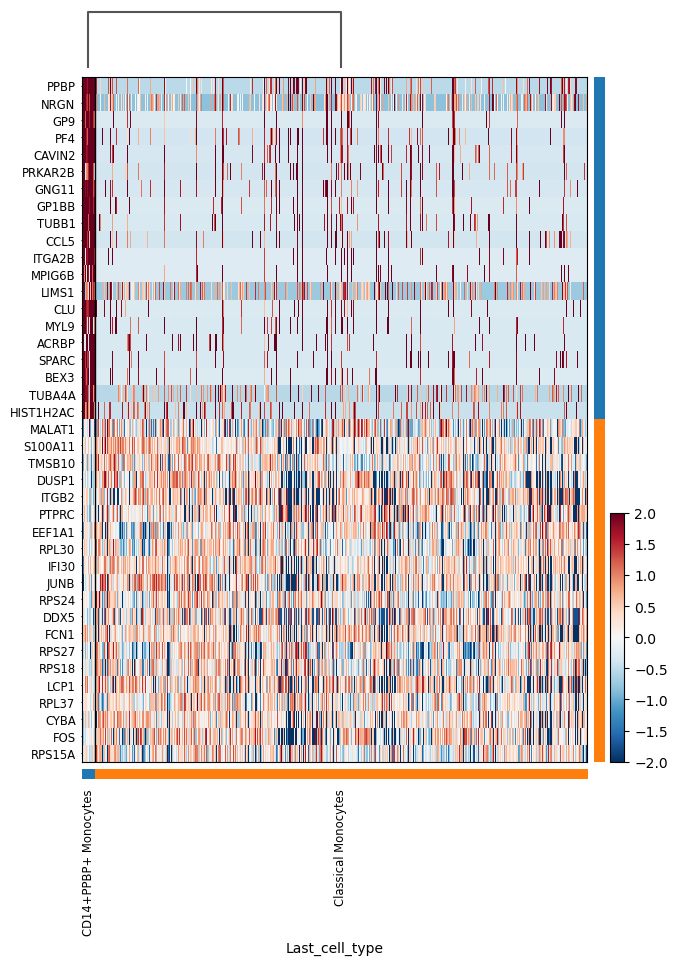

In [12]:
sc.pl.rank_genes_groups_heatmap(submono,show_gene_labels=True,n_genes=20, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='RdBu_r', layer='scaled', figsize=(7,10), show=False);

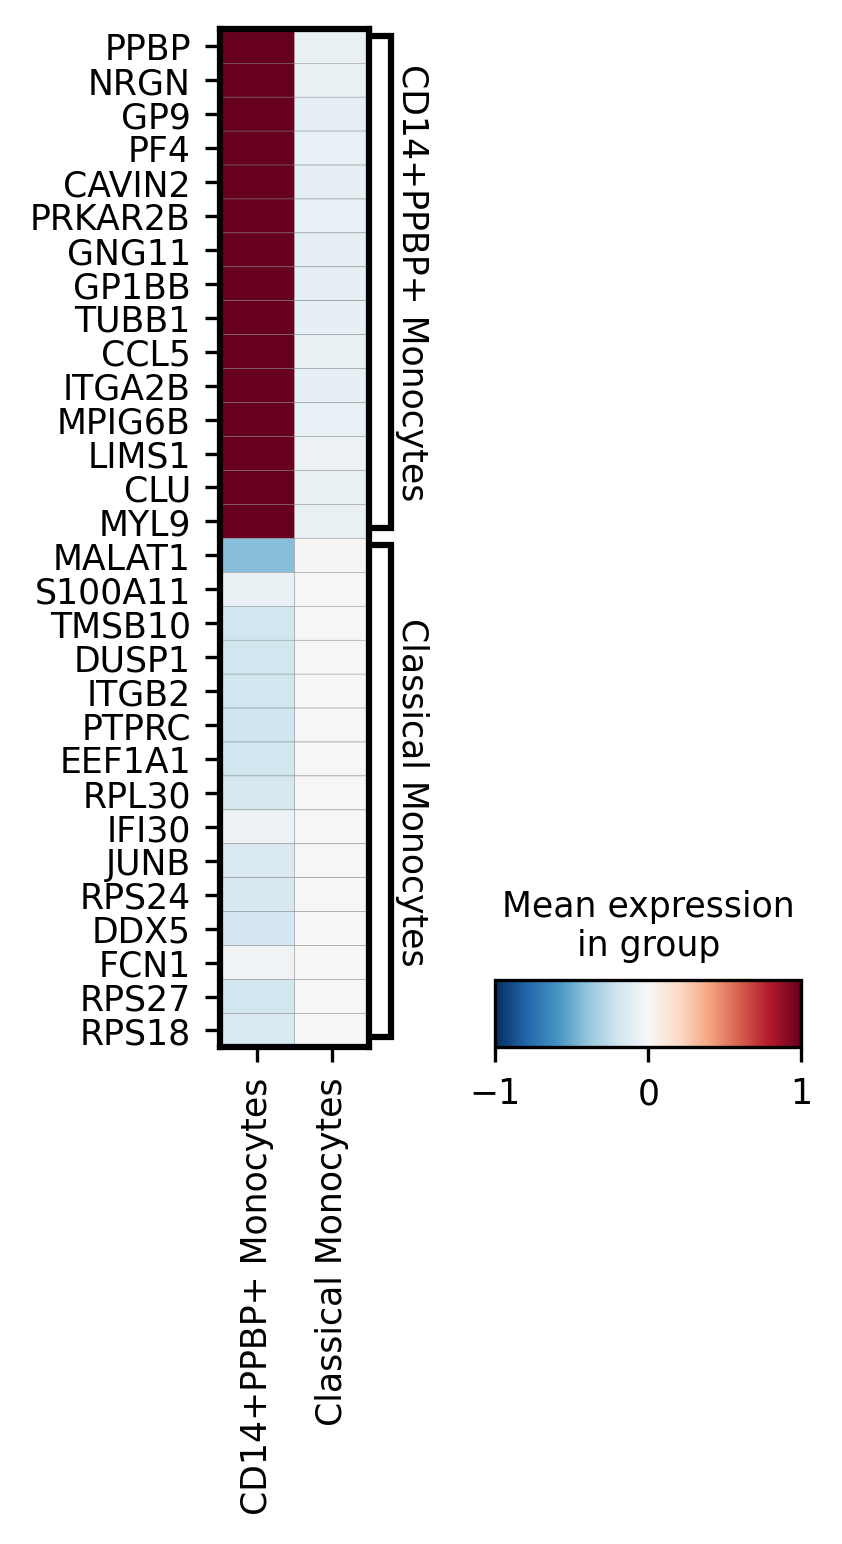

In [28]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = [3, 2]
plt.rcParams['figure.dpi'] = 300
sc.pl.rank_genes_groups_matrixplot(submono, n_genes=15, use_raw=False, vmin=-1, vmax=1, cmap='RdBu_r', layer='scaled',swap_axes=True,show=False, figsize=(2.5,4))
plt.savefig("/home/maolp/Main_Gao_ScanpyProject20231130/HFB_Figure_Plot/Sup_Figure3/S13/S10.pdf",bbox_inches='tight')

In [13]:
df3 = sc.get.rank_genes_groups_df(submono, group=None)

print(df3[1:20])

                   group      names     scores  logfoldchanges  pvals  \
1   CD14+PPBP+ Monocytes       NRGN  44.953823        4.681250    0.0   
2   CD14+PPBP+ Monocytes        GP9  44.901703        6.330556    0.0   
3   CD14+PPBP+ Monocytes        PF4  44.748447        6.017288    0.0   
4   CD14+PPBP+ Monocytes     CAVIN2  44.522415        5.784245    0.0   
5   CD14+PPBP+ Monocytes    PRKAR2B  44.349327        5.550537    0.0   
6   CD14+PPBP+ Monocytes      GNG11  44.028381        5.747788    0.0   
7   CD14+PPBP+ Monocytes      GP1BB  43.847786        5.871026    0.0   
8   CD14+PPBP+ Monocytes      TUBB1  43.515781        6.079325    0.0   
9   CD14+PPBP+ Monocytes       CCL5  42.103401        5.312645    0.0   
10  CD14+PPBP+ Monocytes     ITGA2B  40.696938        5.722864    0.0   
11  CD14+PPBP+ Monocytes     MPIG6B  40.495689        5.622825    0.0   
12  CD14+PPBP+ Monocytes      LIMS1  40.227432        3.472524    0.0   
13  CD14+PPBP+ Monocytes        CLU  39.602901     

In [14]:
mkdir -p /home/maolp/Allcount/All_scanpyData/Monolike

In [15]:
df3[df3.group=='Classical Monocytes'].to_csv("/home/maolp/Allcount/All_scanpyData/Monolike/Classical Monocytes.csv")
df3[df3.group=="'CD14+PPBP+ Monocytes"].to_csv("/home/maolp/Allcount/All_scanpyData/Monolike/CD14+PPBP+ Monocytes.csv")
#df3[df3.group=="PBMC"].to_csv("/home/maolp/Allcount/All_scanpyData/Bcell/PBMC.csv")

In [16]:
Cmono=df3[df3.group=='Classical Monocytes']
PPBP=df3[df3.group=='CD14+PPBP+ Monocytes']
# PBMCB=df3[df3.group=="PBMC"]

In [17]:
%load_ext rpy2.ipython

In [18]:
%%R -i PPBP -i Cmono
Cmono2=subset(Cmono,logfoldchanges>1 &pvals_adj<0.05 &scores >6)
PPBP2=subset(PPBP,logfoldchanges>1 &pvals_adj<0.05 &scores >6)
#PBMCB2=subset(PBMCB,logfoldchanges>1 &pvals_adj<0.05 &scores >6)
# dim(Cmono2)
dim(PPBP2)

# head(LiverB2)


[1] 578   6


In [19]:
%%R
# LiverB=subset(LiverB,logFC>0 &pvals_adj<0.05 &scores >2)
library(clusterProfiler)
library(org.Hs.eg.db)
library(fgsea)
library(msigdbr)

library(clusterProfiler)
library(org.Hs.eg.db)
library(DOSE)

perform_enrichment_analysis <- function(gene_df) {
    # Map gene symbols to Entrez IDs
    map_df <- bitr(gene_df$names, fromType = "SYMBOL", toType = c("ENTREZID"), OrgDb = org.Hs.eg.db)
    
    # Merge the mapped data with the original data
    merged_df <- merge(gene_df, map_df, by.x = "names", by.y = "SYMBOL")
    
    # Perform KEGG enrichment analysis
    enrichKEGG_result <- enrichKEGG(gene = merged_df$ENTREZID, organism = "hsa", 
                                    keyType = "kegg",
                                    pvalueCutoff = 0.05,
                                    pAdjustMethod = "BH",
                                    minGSSize = 10, maxGSSize = 500, 
                                    qvalueCutoff = 0.05,
                                    use_internal_data = FALSE)
    
    # Perform GO enrichment analysis
    enrichGO_result <- enrichGO(merged_df$names, OrgDb = org.Hs.eg.db, ont = 'ALL', 
                                pAdjustMethod = 'BH', pvalueCutoff = 0.05, 
                                qvalueCutoff = 0.05, keyType = 'SYMBOL')
    
    # Return a list with the results
    return(list("KEGG" = enrichKEGG_result, "GO" = enrichGO_result))
}



R[write to console]: 

R[write to console]: clusterProfiler v4.7.1.002  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

R[write to console]: 
载入程辑包：‘clusterProfiler’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: 载入需要的程辑包：AnnotationDbi

R[write to console]: 载入需要的程辑包：stats4

R[write to console]: 载入需要的程辑包：BiocGenerics

R[write to console]: 
载入程辑包：‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.

In [20]:
%%R
PPBP3=perform_enrichment_analysis(PPBP2)

R[write to console]: 'select()' returned 1:many mapping between keys and columns

R[write to console]: Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

R[write to console]: Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



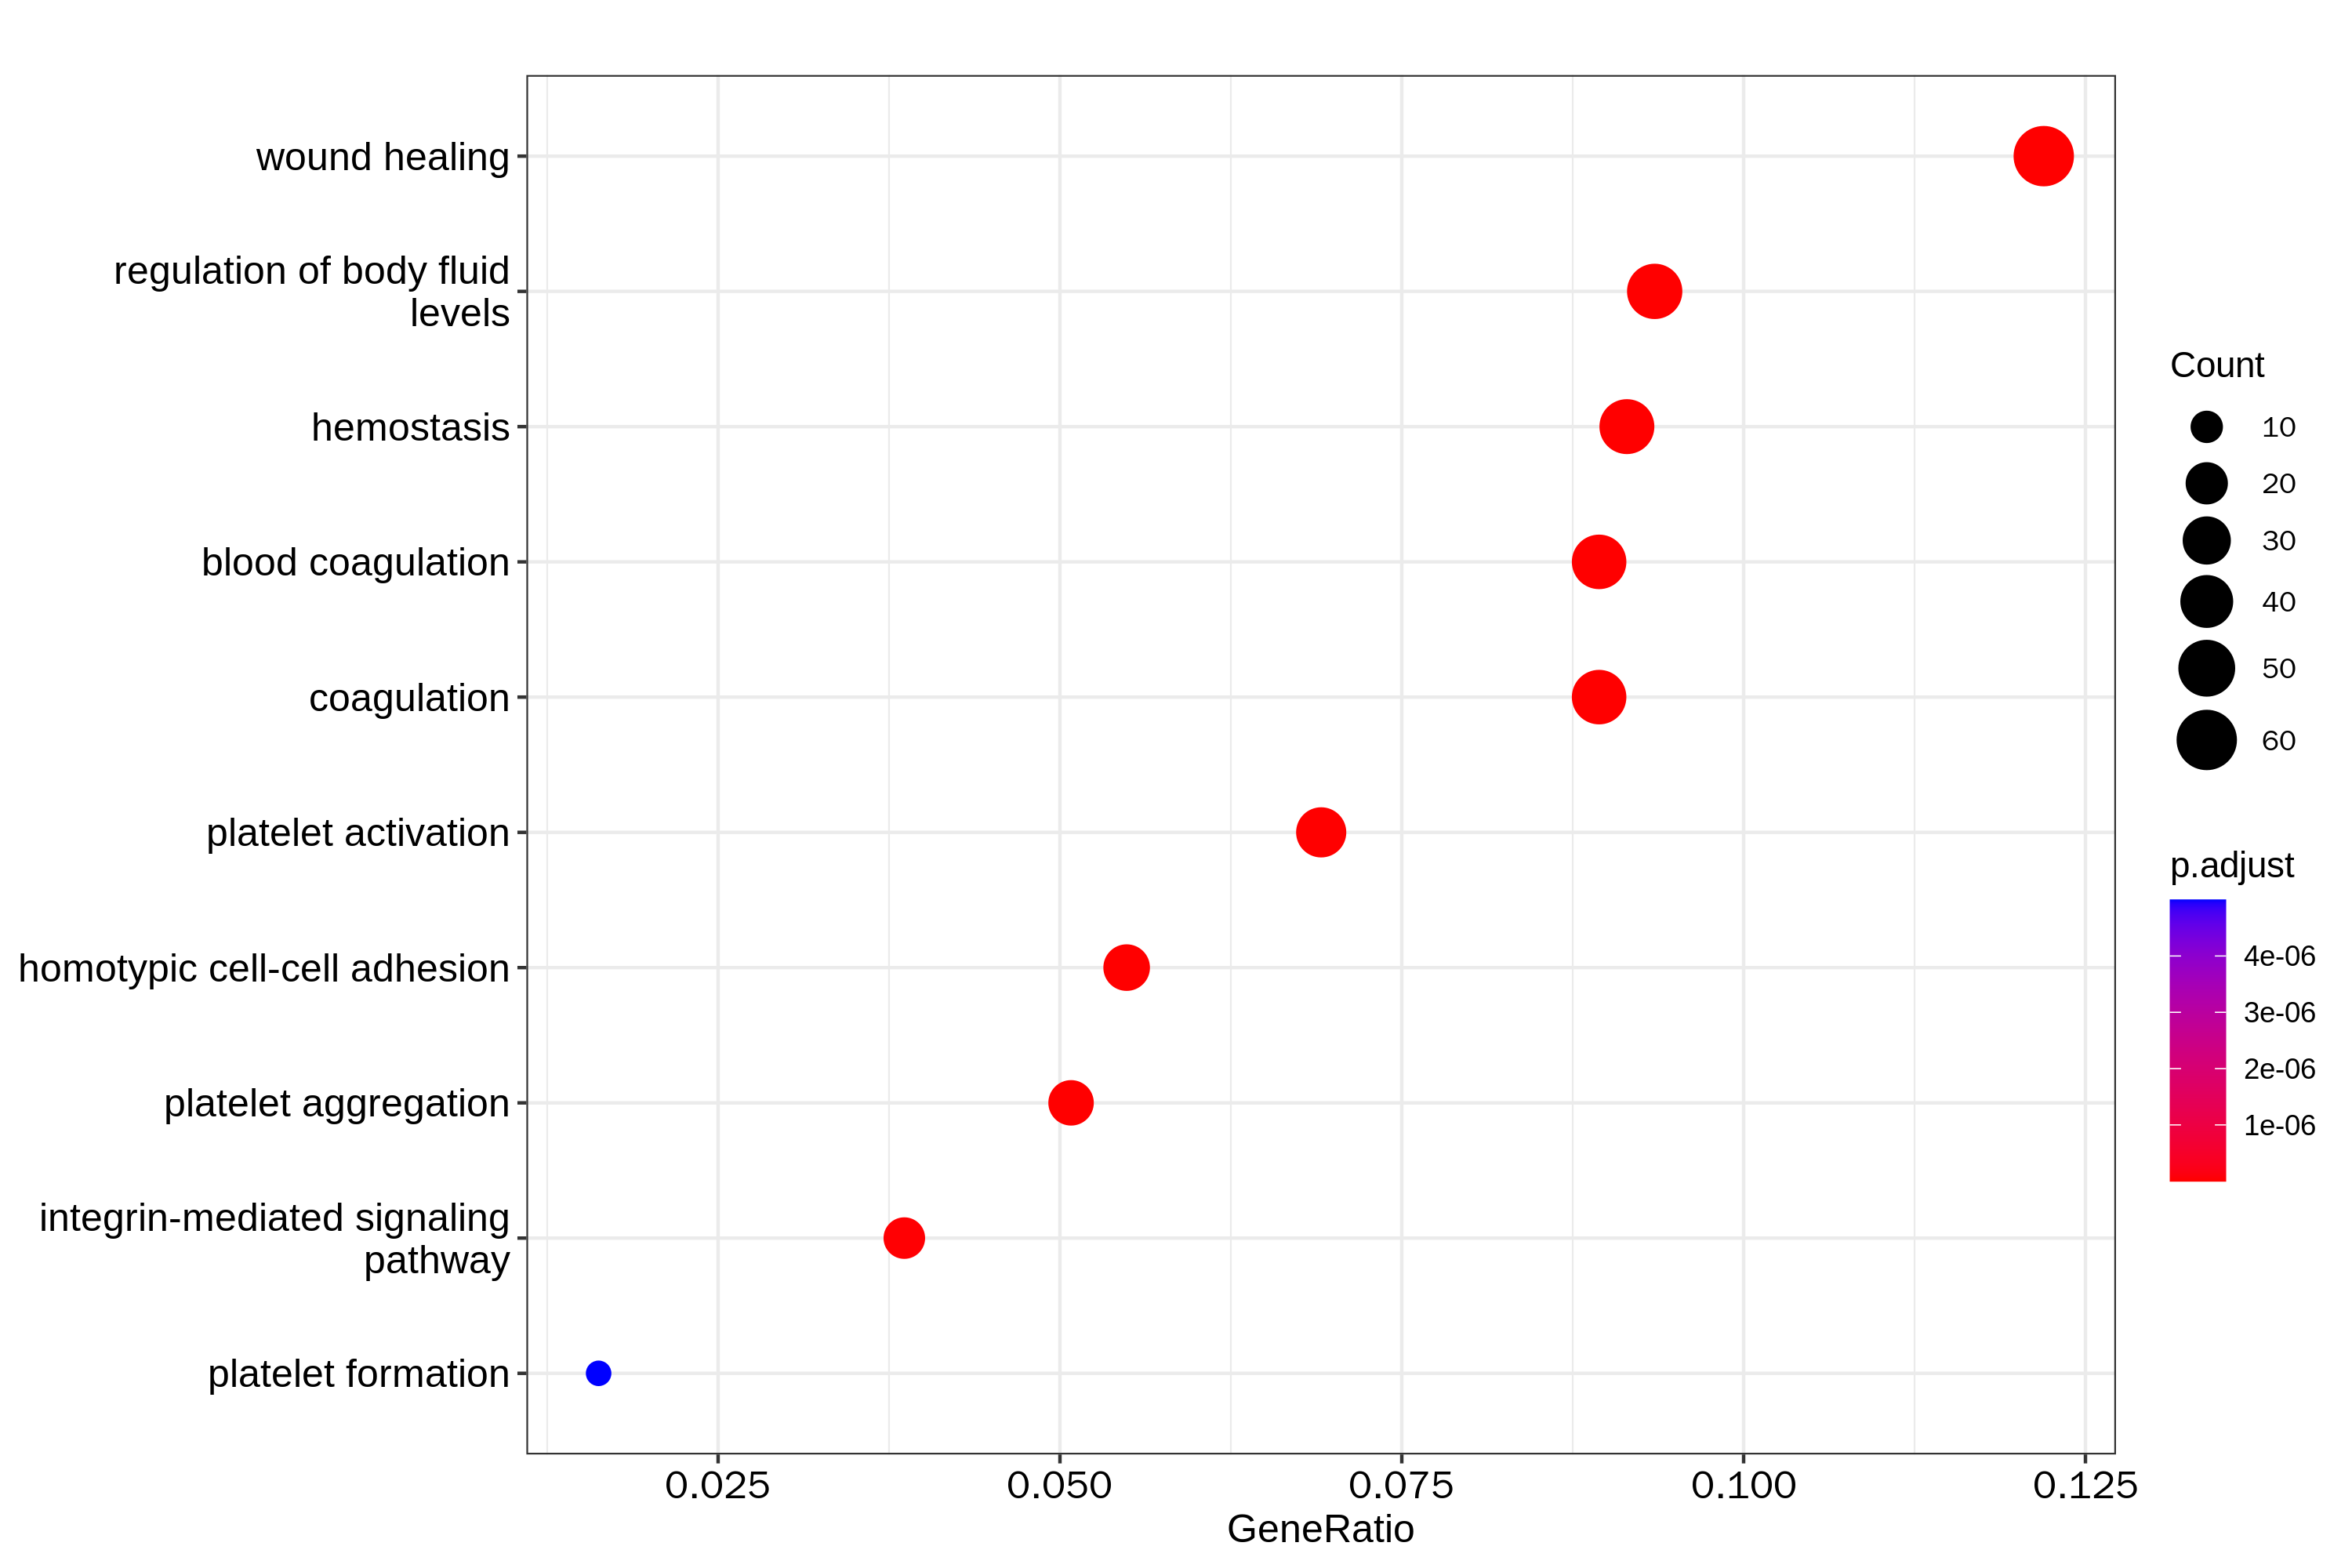

In [21]:
%%R -w 3000 -h 2000 -r 300
write.csv(PPBP3$GO,"/home/maolp/Allcount/All_scanpyData/Monolike/PPBP3_GO.csv")
dotplot(PPBP3$GO)